# Sen12MS Overview

A notebook to investigate regions and class distributions

Author: Marc Rußwurm

In [24]:
import rasterio
with rasterio.open('/workspace/app/data/sen12ms/ROIs1158_spring/s2_101/ROIs1158_spring_s2_101_p138.tif') as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)
    

256 256
EPSG:32652
| 10.00, 0.00, 664582.78|
| 0.00,-10.00, 3628552.77|
| 0.00, 0.00, 1.00|
13
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)


In [2]:
!ls /workspace/app/data

sen12ms


In [3]:
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import rasterio
import numpy as np
from pyproj import Proj, transform


root = "/workspace/app/data/sen12ms"

classes = [
    "Evergreen Needleleaf Forests",
    "Evergreen Broadleaf Forests",
    "Deciduous Needleleaf Forests",
    "Deciduous Broadleaf Forests",
    "Mixed Forests",
    "Closed (Dense) Shrublands",
    "Open (Sparse) Shrublands",
    "Woody Savannas",
    "Savannas",
    "Grasslands",
    "Permanent Wetlands",
    "Croplands",
    "Urban and Built-Up Lands",
    "Cropland/Natural Vegetation Mosaics",
    "Permanent Snow and Ice",
    "Barren",
    "Water Bodies"
]

## Iterate through files

In [6]:
tiles = pd.DataFrame(glob.glob(os.path.join(root,'*','*','*.tif')), columns=["path"])
split = tiles["path"].apply(lambda path: os.path.basename(path).split('_'))
split = pd.DataFrame.from_records(split, columns=["seed","season","sensor","region","tile"])
tiles = tiles.join(split)
tiles

,path,seed,season,sensor,region,tile
0,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p149.tif
1,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p510.tif
2,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p410.tif
3,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p362.tif
4,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p222.tif
...,...,...,...,...,...,...
541981,/workspace/app/data/sen12ms/ROIs1158_spring/s1...,ROIs1158,spring,s1,141,p735.tif
541982,/workspace/app/data/sen12ms/ROIs1158_spring/s1...,ROIs1158,spring,s1,141,p809.tif
541983,/workspace/app/data/sen12ms/ROIs1158_spring/s1...,ROIs1158,spring,s1,141,p197.tif
541984,/workspace/app/data/sen12ms/ROIs1158_spring/s1...,ROIs1158,spring,s1,141,p681.tif


## Read label tifs and store pixel histograms

In [7]:

lc = tiles.loc[tiles["sensor"] == "lc"]

if os.path.exists(os.path.join(root,"histogram.csv")):
    histogram = pd.read_csv(os.path.join(root,"histogram.csv"), index_col=0)
else:
    def get_histogram(path):
        with rasterio.open(path, 'r') as src:
            arr = src.read(1)
        counts = np.histogram(arr,bins=len(classes), range=(0,len(classes)))[0]
        return dict(zip(classes,counts))

    histograms = lc["path"].apply(get_histogram)
    histogram = pd.DataFrame(histograms.to_list(), index=histograms.index)
    histogram = lc.join(histogram)
    histogram.to_csv(os.path.join(root,"histogram.csv"))

## Class Distribution by Region

/home/marc/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


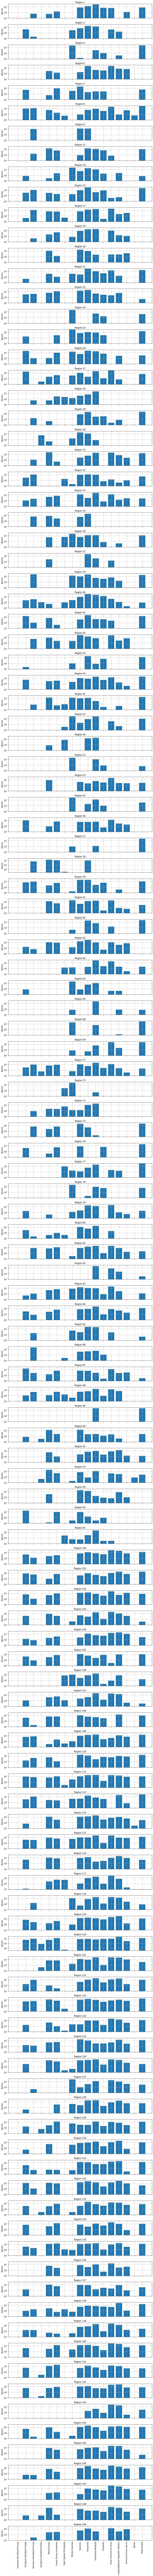

In [4]:

histogram_per_region = histogram.groupby("region").sum()[classes]
regions = histogram["region"].unique()

fig,axs = plt.subplots(125,1,figsize=(12,200),sharex=True)

ax = axs[0]
for ax,i in zip(axs,range(len(axs))):
    d = histogram_per_region.iloc[i]
    ax.bar(d.index, d.values)
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set_yscale('log')
    ax.set_yticks([1e3,1e5,1e7])
    ax.set_ylim(0,1e8)
    ax.set_title(f"Region {d.name}")
    ax.set_ylabel("#pixels")

for tick in axs[-1].get_xticklabels():
    tick.set_rotation(90)
    
fig.tight_layout()

## Class Distribution by Season

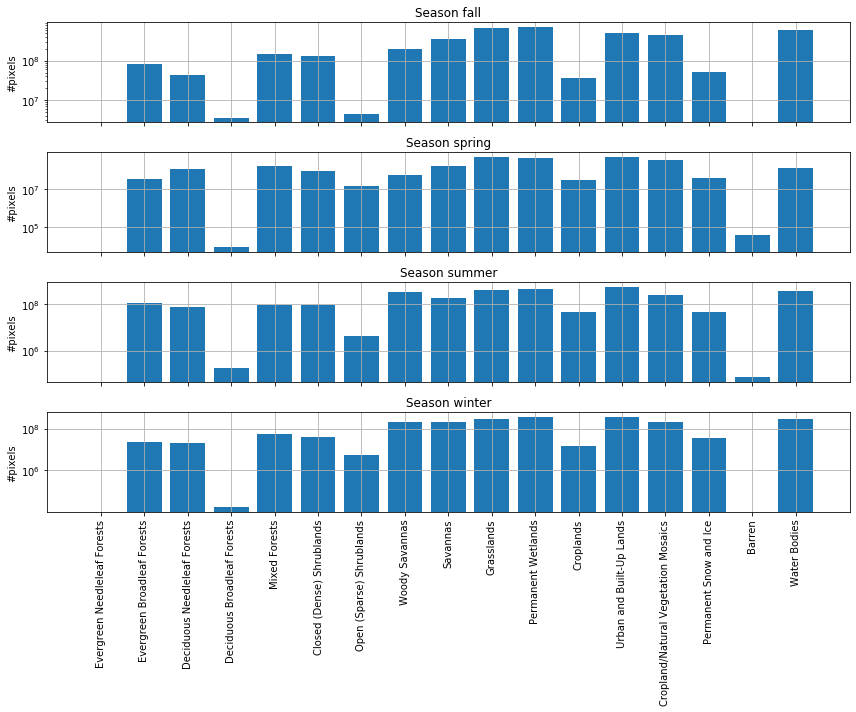

In [5]:
histogram_per_season = histogram.groupby("season").sum()[classes]
regions = histogram["region"].unique()

fig,axs = plt.subplots(4,1,figsize=(12,10),sharex=True)

ax = axs[0]
for ax,i in zip(axs,range(len(axs))):
    d = histogram_per_season.iloc[i]
    ax.bar(d.index, d.values)
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set_yscale('log')
    #ax.set_yticks([1e3,1e5,1e7])
    #ax.set_ylim(0,1e8)
    ax.set_title(f"Season {d.name}")
    ax.set_ylabel("#pixels")

for tick in axs[-1].get_xticklabels():
    tick.set_rotation(90)
    
fig.tight_layout()

## Total Class Distribution

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


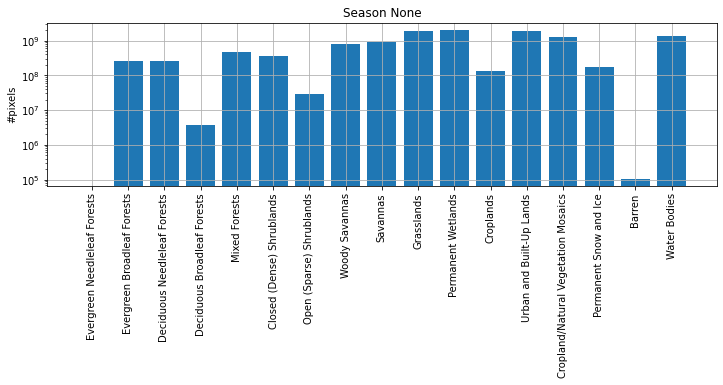

In [8]:
total = histogram[classes].sum(0)

fig,ax = plt.subplots(1,1,figsize=(12,3))

d = total
ax.bar(d.index, d.values)
ax.xaxis.grid()
ax.yaxis.grid()
ax.set_yscale('log')
#ax.set_yticks([1e3,1e5,1e7])
#ax.set_ylim(0,1e8)
ax.set_title(f"Season {d.name}")
ax.set_ylabel("#pixels")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
fig.tight_layout()

## Get region location

In [ ]:
def get_xy(path):
    with rasterio.open(path, 'r') as src:
        trafo = src.transform
        crs = src.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)

    return x,y

regions = lc.groupby("region").first()
xy = pd.DataFrame.from_records(regions["path"].apply(get_xy), columns=["x","y"])
regions = regions.reset_index().join(xy)

## Plot region location

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  


(-20026376.39, 20026376.39, -10000000.0, 15000000.0)

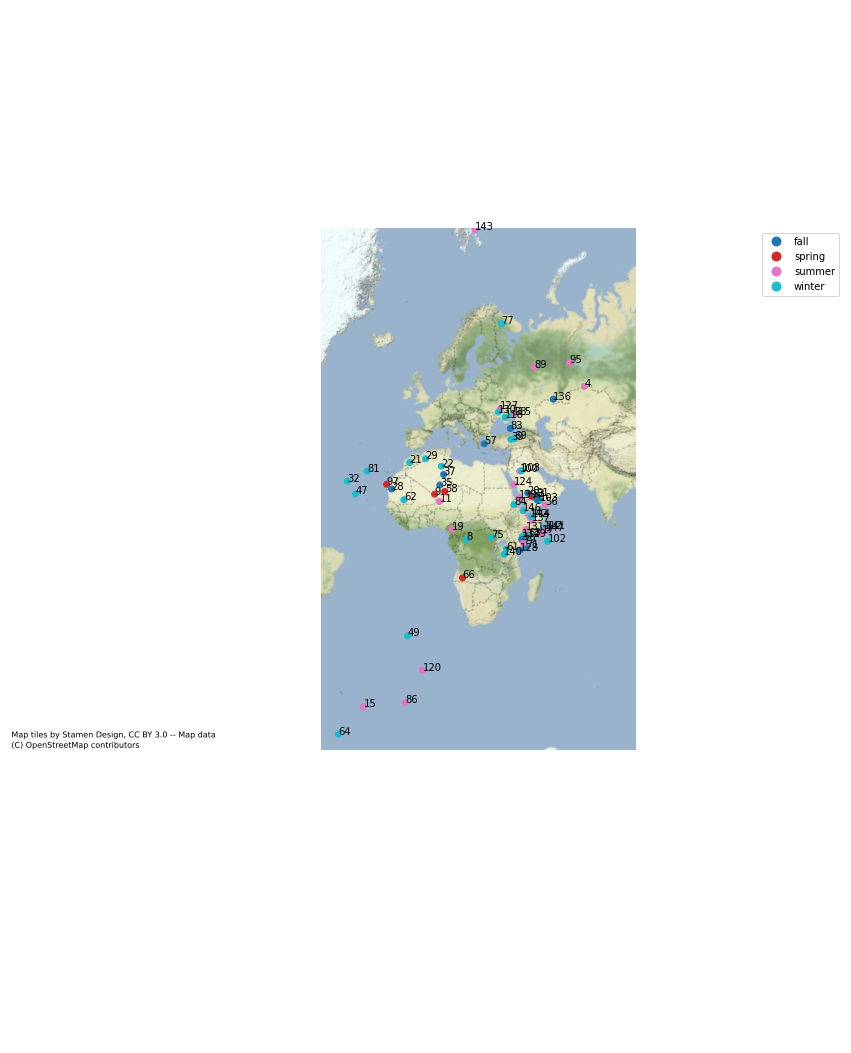

In [10]:
gdf = gpd.GeoDataFrame(regions, geometry=gpd.points_from_xy(regions.y, regions.x),crs=4326).to_crs(epsg=3857)

fig,ax=plt.subplots(figsize=(15,16))
gdf.plot(ax=ax,column="season",legend=True)
#ax.scatter(gdf.geometry.x,gdf.geometry.y, c=gdf.season)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TerrainBackground,zoom=3)

for x,y,region in zip(gdf.geometry.x,gdf.geometry.y,gdf.region):
    ax.annotate(region,(x,y))

ax.set_xlim(-20026376.39,20026376.39)
ax.set_ylim(-1e7, 1.5e7)
ax.axis('off')

## Save shapefile

In [9]:
gdf.to_file("regions.shp")